# Introduction

Notebook to analyze the **False Negatives** Results for each model in the context of traceability between **test cases** and **bug reports**.

# Load Libraries and Datasets

In [1]:
from mod_finder_util import mod_finder_util
mod_finder_util.add_modules_origin_search_path()

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

from modules.models_runner.tc_br_models_runner import TC_BR_Runner
from modules.utils import model_evaluator as m_eval
from modules.utils import aux_functions
from modules.utils import firefox_dataset_p2 as fd
from modules.utils import similarity_measures as sm
from modules.utils import tokenizers as tok

import warnings; warnings.simplefilter('ignore')

# Run All Models

## Volunteers Only Strategy

In [2]:
models_runner_4 = TC_BR_Runner()

lsi_model_4 = models_runner_4.run_lsi_model()
lda_model_4 = models_runner_4.run_lda_model()
bm25_model_4 = models_runner_4.run_bm25_model()
w2v_model_4 = models_runner_4.run_word2vec_model()

oracle=fd.Tc_BR_Oracles.read_oracle_volunteers_df()

evaluator_4 = m_eval.ModelEvaluator(oracle)
evals_df_4 = evaluator_4.run_evaluator(models=[lsi_model_4,lda_model_4,bm25_model_4,w2v_model_4],
                                       top_values=[1,3,5,10], 
                                       sim_thresholds=[(sm.SimilarityMeasure.COSINE, x/10) for x in range(0,10)])

TestCases.shape: (195, 12)
SelectedBugReports.shape: (91, 18)
Running LSI Model ------
Running LDA Model -----
Running BM25 Model -----
Running W2V Model ------
OracleVolunteers.shape: (195, 91)
Evaluating LSI Model ----- 
Evaluating LDA Model ----- 
Evaluating BM25 Model ----- 
Evaluating WORDVECTOR Model ----- 


### Load Datasets

In [3]:
bugreports = fd.Datasets.read_selected_bugreports_df()
testcases = fd.Datasets.read_testcases_df()

SelectedBugReports.shape: (91, 18)
TestCases.shape: (195, 12)


### Tokenization

In [4]:
tokenizer = tok.PorterStemmerBased_Tokenizer()
bugreports['tokens'] = bugreports.apply(lambda row : tokenizer.__call__(row['br_desc']), axis=1)
testcases['tokens'] = testcases.apply(lambda row : tokenizer.__call__(row['tc_desc']), axis=1)

### Results

In [5]:
evals_df_4.head()

,model,ref_name,perc_precision,perc_recall,perc_fscore,eval_df,sim_threshold,top,trace_links_df
0,lsi,top_1_cosine_0.0,30.77,1.93,3.57,precision recall fscore ...,0.0,1.0,br_name BR_1248267_SRC BR_1248268_SRC BR...
1,lsi,top_1_cosine_0.1,30.77,1.93,3.57,precision recall fscore ...,0.1,1.0,br_name BR_1248267_SRC BR_1248268_SRC BR...
2,lsi,top_1_cosine_0.2,30.77,1.93,3.57,precision recall fscore ...,0.2,1.0,br_name BR_1248267_SRC BR_1248268_SRC BR...
3,lsi,top_1_cosine_0.3,30.77,1.93,3.57,precision recall fscore ...,0.3,1.0,br_name BR_1248267_SRC BR_1248268_SRC BR...
4,lsi,top_1_cosine_0.4,28.57,1.86,3.44,precision recall fscore ...,0.4,1.0,br_name BR_1248267_SRC BR_1248268_SRC BR...


### Grouping Results by Model

#### Min Recall

model
bm25          1.86
lda           0.14
lsi           0.00
wordvector    0.63
Name: perc_recall, dtype: float64



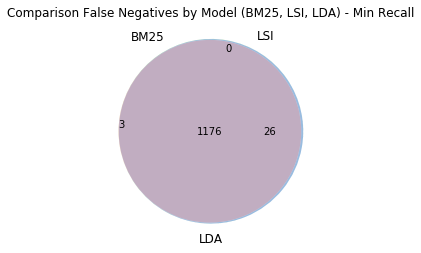

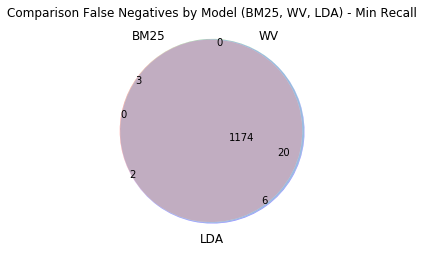

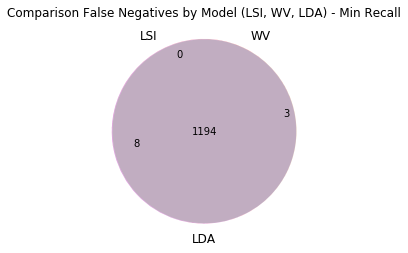

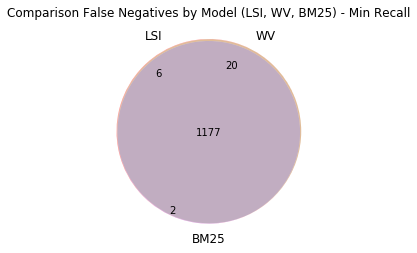

In [6]:
group = evals_df_4.groupby('model').perc_recall.min()
print(group)
print()

bm25_min_recall = group[group.index == 'bm25'].values[0]
lsi_min_recall = group[group.index == 'lsi'].values[0]
lda_min_recall = group[group.index == 'lda'].values[0]
wv_min_recall = group[group.index == 'wordvector'].values[0]

bm25_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_recall=bm25_min_recall))
lsi_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_recall=lsi_min_recall))
lda_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_recall=lda_min_recall))
wv_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_recall=wv_min_recall))

venn3([bm25_fn_set, lsi_fn_set, lda_fn_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Negatives by Model (BM25, LSI, LDA) - Min Recall')
plt.show()

venn3([bm25_fn_set, wv_fn_set, lda_fn_set], ['BM25','WV','LDA'])
plt.title('Comparison False Negatives by Model (BM25, WV, LDA) - Min Recall')
plt.show()

venn3([lsi_fn_set, wv_fn_set, lda_fn_set], ['LSI','WV','LDA'])
plt.title('Comparison False Negatives by Model (LSI, WV, LDA) - Min Recall')
plt.show()

venn3([lsi_fn_set, wv_fn_set, bm25_fn_set], ['LSI','WV','BM25'])
plt.title('Comparison False Negatives by Model (LSI, WV, BM25) - Min Recall')
plt.show()

##### Exclusive Cases

In [7]:
print("BM25 Exclusive FN:")
bm25_exc_set = bm25_fn_set - lsi_fn_set - lda_fn_set - wv_fn_set
display(bm25_exc_set)

print("\n\nLSI Exclusive FN:")
lsi_exc_set = lsi_fn_set - bm25_fn_set - lda_fn_set - wv_fn_set
display(lsi_exc_set)

print("\n\nLDA Exclusive FN:")
lda_exc_set = lda_fn_set - lsi_fn_set - bm25_fn_set - wv_fn_set
display(lda_exc_set)

print("\n\nWV Exclusive FN:")
wv_exc_set = wv_fn_set - lda_fn_set - lsi_fn_set - bm25_fn_set
display(wv_exc_set)

BM25 Exclusive FN:


set()



LSI Exclusive FN:


set()



LDA Exclusive FN:


set()



WV Exclusive FN:


set()

#### Max Recall

model
bm25          14.20
lda            8.35
lsi           14.42
wordvector     5.05
Name: perc_recall, dtype: float64



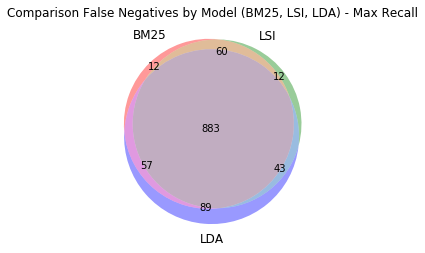

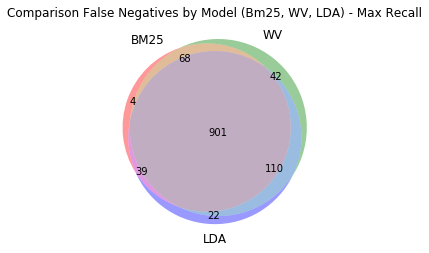

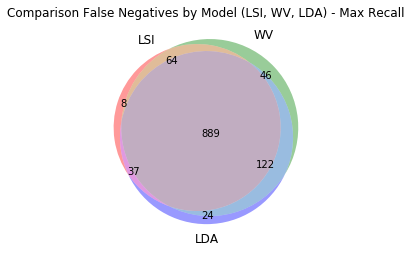

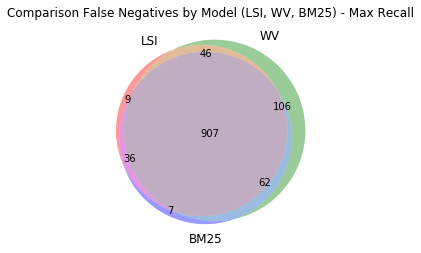

In [8]:
group = evals_df_4.groupby('model').perc_recall.max()
print(group)
print()

bm25_max_recall = group[group.index == 'bm25'].values[0]
lsi_max_recall = group[group.index == 'lsi'].values[0]
lda_max_recall = group[group.index == 'lda'].values[0]
wv_max_recall = group[group.index == 'wordvector'].values[0]

bm25_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_recall=bm25_max_recall))
lsi_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_recall=lsi_max_recall))
lda_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_recall=lda_max_recall))
wv_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_recall=wv_max_recall))

venn3([bm25_fn_set, lsi_fn_set, lda_fn_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Negatives by Model (BM25, LSI, LDA) - Max Recall')
plt.show()

venn3([bm25_fn_set, wv_fn_set, lda_fn_set], ['BM25','WV','LDA'])
plt.title('Comparison False Negatives by Model (Bm25, WV, LDA) - Max Recall')
plt.show()

venn3([lsi_fn_set, wv_fn_set, lda_fn_set], ['LSI','WV','LDA'])
plt.title('Comparison False Negatives by Model (LSI, WV, LDA) - Max Recall')
plt.show()

venn3([lsi_fn_set, wv_fn_set, bm25_fn_set], ['LSI','WV','BM25'])
plt.title('Comparison False Negatives by Model (LSI, WV, BM25) - Max Recall')
plt.show()

##### Exclusive Cases

In [9]:
print("BM25 Exclusive FN:")
bm25_exc_set = bm25_fn_set - lsi_fn_set - lda_fn_set - wv_fn_set
display(bm25_exc_set)

print("\n\nLSI Exclusive FN:")
lsi_exc_set = lsi_fn_set - bm25_fn_set - lda_fn_set - wv_fn_set
display(lsi_exc_set)

print("\n\nLDA Exclusive FN:")
lda_exc_set = lda_fn_set - lsi_fn_set - bm25_fn_set - wv_fn_set
display(lda_exc_set)

print("\n\nWV Exclusive FN:")
wv_exc_set = wv_fn_set - lda_fn_set - lsi_fn_set - bm25_fn_set
display(wv_exc_set)

BM25 Exclusive FN:


{('TC_79_TRG', 'BR_1270983_SRC'), ('TC_80_TRG', 'BR_1270983_SRC')}



LSI Exclusive FN:


{('TC_100_TRG', 'BR_1299458_SRC'),
 ('TC_14_TRG', 'BR_1264988_SRC'),
 ('TC_14_TRG', 'BR_1279864_SRC'),
 ('TC_14_TRG', 'BR_1365887_SRC'),
 ('TC_160_TRG', 'BR_1292566_SRC'),
 ('TC_163_TRG', 'BR_1287384_SRC')}



LDA Exclusive FN:


{('TC_104_TRG', 'BR_1300738_SRC'),
 ('TC_107_TRG', 'BR_1300738_SRC'),
 ('TC_130_TRG', 'BR_1314643_SRC'),
 ('TC_14_TRG', 'BR_1297374_SRC'),
 ('TC_14_TRG', 'BR_1311998_SRC'),
 ('TC_14_TRG', 'BR_1334844_SRC'),
 ('TC_14_TRG', 'BR_1335992_SRC'),
 ('TC_14_TRG', 'BR_1339497_SRC'),
 ('TC_14_TRG', 'BR_1352539_SRC'),
 ('TC_14_TRG', 'BR_1357458_SRC'),
 ('TC_160_TRG', 'BR_1432915_SRC'),
 ('TC_161_TRG', 'BR_1432915_SRC'),
 ('TC_181_TRG', 'BR_1345687_SRC'),
 ('TC_193_TRG', 'BR_1296322_SRC'),
 ('TC_193_TRG', 'BR_1345687_SRC'),
 ('TC_205_TRG', 'BR_1305195_SRC'),
 ('TC_62_TRG', 'BR_1353831_SRC'),
 ('TC_76_TRG', 'BR_1248267_SRC'),
 ('TC_90_TRG', 'BR_1270983_SRC')}



WV Exclusive FN:


{('TC_106_TRG', 'BR_1300738_SRC'),
 ('TC_13_TRG', 'BR_1297374_SRC'),
 ('TC_13_TRG', 'BR_1335992_SRC'),
 ('TC_13_TRG', 'BR_1352539_SRC'),
 ('TC_148_TRG', 'BR_1365887_SRC'),
 ('TC_14_TRG', 'BR_1293308_SRC'),
 ('TC_154_TRG', 'BR_1292566_SRC'),
 ('TC_156_TRG', 'BR_1287384_SRC'),
 ('TC_156_TRG', 'BR_1292573_SRC'),
 ('TC_157_TRG', 'BR_1287384_SRC'),
 ('TC_157_TRG', 'BR_1292573_SRC'),
 ('TC_160_TRG', 'BR_1297686_SRC'),
 ('TC_162_TRG', 'BR_1292566_SRC'),
 ('TC_163_TRG', 'BR_1292573_SRC'),
 ('TC_164_TRG', 'BR_1287384_SRC'),
 ('TC_164_TRG', 'BR_1292566_SRC'),
 ('TC_165_TRG', 'BR_1287384_SRC'),
 ('TC_169_TRG', 'BR_1287384_SRC'),
 ('TC_16_TRG', 'BR_1294733_SRC'),
 ('TC_16_TRG', 'BR_1294887_SRC'),
 ('TC_16_TRG', 'BR_1297976_SRC'),
 ('TC_16_TRG', 'BR_1311998_SRC'),
 ('TC_16_TRG', 'BR_1353831_SRC'),
 ('TC_16_TRG', 'BR_1357458_SRC'),
 ('TC_16_TRG', 'BR_1408361_SRC'),
 ('TC_17_TRG', 'BR_1408361_SRC'),
 ('TC_181_TRG', 'BR_1296322_SRC'),
 ('TC_18_TRG', 'BR_1294733_SRC'),
 ('TC_18_TRG', 'BR_1294887_SRC'),

##### Word Clouds

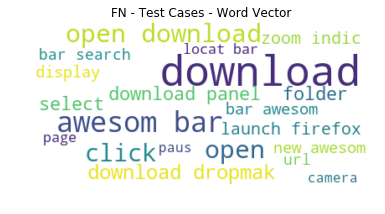

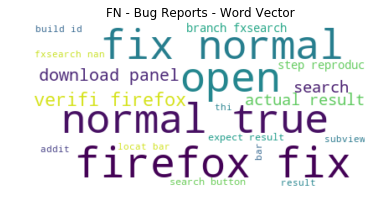

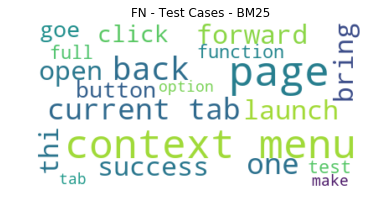

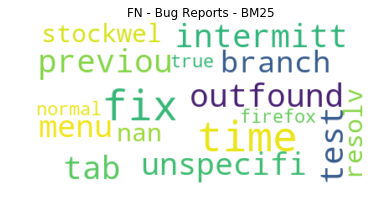

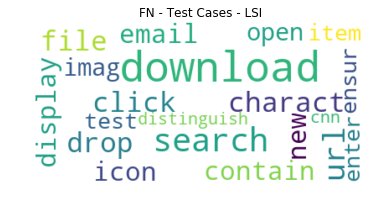

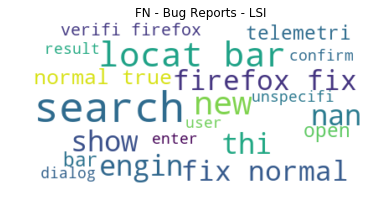

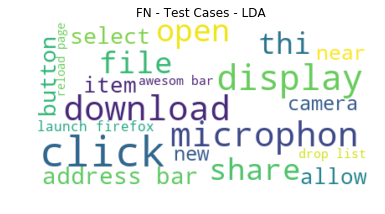

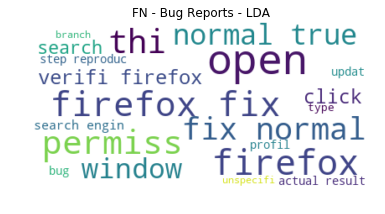

In [10]:
aux_functions.create_wordcloud_tc_br(wv_exc_set, bugreports=bugreports, testcases=testcases,
                                    wc_tc_title="FN - Test Cases - Word Vector",
                                    wc_br_title="FN - Bug Reports - Word Vector")

aux_functions.create_wordcloud_tc_br(bm25_exc_set, bugreports=bugreports, testcases=testcases,
                                    wc_tc_title="FN - Test Cases - BM25",
                                    wc_br_title="FN - Bug Reports - BM25")

aux_functions.create_wordcloud_tc_br(lsi_exc_set, bugreports=bugreports, testcases=testcases,
                                    wc_tc_title="FN - Test Cases - LSI",
                                    wc_br_title="FN - Bug Reports - LSI")

aux_functions.create_wordcloud_tc_br(lda_exc_set, bugreports=bugreports, testcases=testcases,
                                    wc_tc_title="FN - Test Cases - LDA",
                                    wc_br_title="FN - Bug Reports - LDA")


In [11]:
print("LSI FN Amount: {}".format(len(lsi_fn_set)))
print("LDA FN Amount: {}".format(len(lda_fn_set)))
print("BM25 FN Amount: {}".format(len(bm25_fn_set)))
print("WV FN Amount: {}".format(len(wv_fn_set)))

LSI FN Amount: 998
LDA FN Amount: 1072
BM25 FN Amount: 1012
WV FN Amount: 1121


##### Detailing Features for Exclusive Sets

In [19]:
aux_functions.detail_features(bm25_exc_set, bugreports=bugreports, testcases=testcases)
aux_functions.detail_features(lda_exc_set, bugreports=bugreports, testcases=testcases)
aux_functions.detail_features(lsi_exc_set, bugreports=bugreports, testcases=testcases)
aux_functions.detail_features(wv_exc_set, bugreports=bugreports, testcases=testcases)

,tc,tc_feat,br,br_summary
0,TC_80_TRG,Context Menu,BR_1270983_SRC,Intermittent browser_contextmenu.jsTest timed outFound a tab after previous test timed out: subtst_contextmenu.html -
1,TC_79_TRG,Context Menu,BR_1270983_SRC,Intermittent browser_contextmenu.jsTest timed outFound a tab after previous test timed out: subtst_contextmenu.html -


,tc,tc_feat,br,br_summary
0,TC_181_TRG,Indicator for device permissions,BR_1345687_SRC,[Regression] Clicking on audioVideoButton / sharing-icon don't work when typed on urlbar
1,TC_107_TRG,Windows 10 Compatibility,BR_1300738_SRC,Firefox post update corrupts Windows 10 user profiles when using registry protection software
2,TC_14_TRG,New Awesome Bar,BR_1311998_SRC,[One-off searches] Right click on a result from Awesomebar closes the dropdown
3,TC_104_TRG,Windows 10 Compatibility,BR_1300738_SRC,Firefox post update corrupts Windows 10 user profiles when using registry protection software
4,TC_14_TRG,New Awesome Bar,BR_1352539_SRC,Move defaultenginename pref setting into list.json
5,TC_130_TRG,Pointer Lock API,BR_1314643_SRC,[One-off searches] Changing the default search engine from Search bar does not work first time
6,TC_161_TRG,Downloads Dropmaker,BR_1432915_SRC,Do not write the kMDItemWhereFroms xattr metadata for files downloaded in Private Browsing mode
7,TC_90_TRG,Context Menu,BR_1270983_SRC,Intermittent browser_contextmenu.jsTest timed outFound a tab after previous test timed out: subtst_contextmenu.html -
8,TC_62_TRG,Browser Customization,BR_1353831_SRC,OneOff block in search bar doesn't update text if Customize was opened at least once
9,TC_193_TRG,Indicator for device permissions,BR_1296322_SRC,X button is vertically misaligned on the permission dropdown


,tc,tc_feat,br,br_summary
0,TC_160_TRG,Downloads Dropmaker,BR_1292566_SRC,"The ""open"" button in the subview for temporarily blocked downloads should not ask for confirmation"
1,TC_14_TRG,New Awesome Bar,BR_1365887_SRC,Can't open resource:///modules/ from the location bar
2,TC_14_TRG,New Awesome Bar,BR_1279864_SRC,The new location bar autocomplete drop down menu starting from 48 has serious performance issue and often blocks user's <Enter> input
3,TC_163_TRG,Downloads Dropmaker,BR_1287384_SRC,Incorrect alignment of Summary section in Downloads panel
4,TC_14_TRG,New Awesome Bar,BR_1264988_SRC,Scrollbar appears for a moment in the new Awesomebar Resultlist
5,TC_100_TRG,Context Menu,BR_1299458_SRC,Telemetry data from Search bar is not properly collected when searching in new tab from context menu


,tc,tc_feat,br,br_summary
0,TC_154_TRG,Downloads Dropmaker,BR_1292566_SRC,"The ""open"" button in the subview for temporarily blocked downloads should not ask for confirmation"
1,TC_16_TRG,New Awesome Bar,BR_1311998_SRC,[One-off searches] Right click on a result from Awesomebar closes the dropdown
2,TC_106_TRG,Windows 10 Compatibility,BR_1300738_SRC,Firefox post update corrupts Windows 10 user profiles when using registry protection software
3,TC_13_TRG,New Awesome Bar,BR_1297374_SRC,"[One-off searches] When changing the default search engine from Awesomebar, the icon of the new default engine is replaced by the icon of the old default engine"
4,TC_156_TRG,Downloads Dropmaker,BR_1292573_SRC,Broken keyboard interaction with the subview in the Downloads Panel
5,TC_198_TRG,Zoom Indicator,BR_1365887_SRC,Can't open resource:///modules/ from the location bar
6,TC_14_TRG,New Awesome Bar,BR_1293308_SRC,System font setting respected by location bar but ignored by location bar's autocomplete drop-down list
7,TC_17_TRG,New Awesome Bar,BR_1408361_SRC,Received tab is truncated prematurely in notification
8,TC_148_TRG,Zoom Indicator,BR_1365887_SRC,Can't open resource:///modules/ from the location bar
9,TC_160_TRG,Downloads Dropmaker,BR_1297686_SRC,"When multiple desktop files support the same protocol scheme, only one of them is listed"


#### Min Precision

In [ ]:
group = evals_df_4.groupby('model').perc_precision.min()
print(group)
print()

bm25_min_prec = group[group.index == 'bm25'].values[0]
lsi_min_prec = group[group.index == 'lsi'].values[0]
lda_min_prec = group[group.index == 'lda'].values[0]
wv_min_prec = group[group.index == 'wordvector'].values[0]

bm25_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_precision=bm25_min_prec))
lsi_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_precision=lsi_min_prec))
lda_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_precision=lda_min_prec))
wv_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_precision=wv_min_prec))

venn3([bm25_fn_set, lsi_fn_set, lda_fn_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Negatives by Model (BM25, LSI, LDA) - Min Precision')
plt.show()

venn3([bm25_fn_set, wv_fn_set, lda_fn_set], ['BM25','WV','LDA'])
plt.title('Comparison False Negatives by Model (BM25, WV, LDA) - Min Precision')
plt.show()

venn3([lsi_fn_set, wv_fn_set, lda_fn_set], ['LSI','WV','LDA'])
plt.title('Comparison False Negatives by Model (LSI, WV, LDA) - Min Precision')
plt.show()

venn3([lsi_fn_set, wv_fn_set, bm25_fn_set], ['LSI','WV','BM25'])
plt.title('Comparison False Negatives by Model (LSI, WV, BM25) - Min Precision')
plt.show()

##### Exclusive Cases

In [ ]:
print("BM25 Exclusive FN:")
bm25_exc_set = bm25_fn_set - lsi_fn_set - lda_fn_set - wv_fn_set
display(bm25_exc_set)

print("\n\nLSI Exclusive FN:")
lsi_exc_set = lsi_fn_set - bm25_fn_set - lda_fn_set - wv_fn_set
display(lsi_exc_set)

print("\n\nLDA Exclusive FN:")
lda_exc_set = lda_fn_set - lsi_fn_set - bm25_fn_set - wv_fn_set
display(lda_exc_set)

print("\n\nWV Exclusive FN:")
wv_exc_set = wv_fn_set - lda_fn_set - lsi_fn_set - bm25_fn_set
display(wv_exc_set)

In [ ]:
print("LSI FN Amount: {}".format(len(lsi_fn_set)))
print("LDA FN Amount: {}".format(len(lda_fn_set)))
print("BM25 FN Amount: {}".format(len(bm25_fn_set)))
print("WV FN Amount: {}".format(len(wv_fn_set)))

#### Max Precision

In [ ]:
group = evals_df_4.groupby('model').perc_precision.max()
print(group)
print()

bm25_max_prec = group[group.index == 'bm25'].values[0]
lsi_max_prec = group[group.index == 'lsi'].values[0]
lda_max_prec = group[group.index == 'lda'].values[0]
wv_max_prec = group[group.index == 'wordvector'].values[0]

bm25_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_precision=bm25_max_prec))
lsi_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_precision=lsi_max_prec))
lda_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_precision=lda_max_prec))
wv_fn_set = aux_functions.get_false_negatives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_precision=wv_max_prec))

venn3([bm25_fn_set, lsi_fn_set, lda_fn_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Negatives by Model (BM25, LSI, LDA) - Max Precision')
plt.show()

venn3([bm25_fn_set, wv_fn_set, lda_fn_set], ['BM25','WV','LDA'])
plt.title('Comparison False Negatives by Model (BM25, WV, LDA) - Max Precision')
plt.show()

venn3([lsi_fn_set, wv_fn_set, lda_fn_set], ['LSI','WV','LDA'])
plt.title('Comparison False Negatives by Model (LSI,WV,LDA) - Max Precision')
plt.show()

venn3([lsi_fn_set, wv_fn_set, bm25_fn_set], ['LSI','WV','BM25'])
plt.title('Comparison False Negatives by Model (LSI, WV, BM25) - Max Precision')
plt.show()

##### Exclusive Cases

In [ ]:
print("BM25 Exclusive FN:")
bm25_exc_set = bm25_fn_set - lsi_fn_set - lda_fn_set - wv_fn_set
display(bm25_exc_set)

print("\n\nLSI Exclusive FN:")
lsi_exc_set = lsi_fn_set - bm25_fn_set - lda_fn_set - wv_fn_set
display(lsi_exc_set)

print("\n\nLDA Exclusive FN:")
lda_exc_set = lda_fn_set - lsi_fn_set - bm25_fn_set - wv_fn_set
display(lda_exc_set)

print("\n\nWV Exclusive FN:")
wv_exc_set = wv_fn_set - lda_fn_set - lsi_fn_set - bm25_fn_set
display(wv_exc_set)

In [ ]:
print("LSI FN Amount: {}".format(len(lsi_fn_set)))
print("LDA FN Amount: {}".format(len(lda_fn_set)))
print("BM25 FN Amount: {}".format(len(bm25_fn_set)))
print("WV FN Amount: {}".format(len(wv_fn_set)))